In [1]:
#conda install matplotlib
# common import abbreviations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import patsy

import itertools as it
import collections as co
import functools as ft
import os.path as osp

import glob
import textwrap

# finally, a better idiom for warnings
import sklearn, warnings
warnings.filterwarnings('ignore',
                        category=FutureWarning,
                        module='sklearn')

# if the warnings get overwhelming,
# you can re-disable with these original lines:
#import warnings
#warnings.filterwarnings("ignore")

# and for the really aggressive warnings:
# some warnings are stubborn in the extreme, we don't want
# them in the book
#def warn(*args, **kwargs):  pass
#warnings.warn = warn

# config related
np.set_printoptions(precision=4,
                    suppress=True)
pd.options.display.float_format = '{:20,.4f}'.format

# there are good reasons *NOT* to do this in any real production code
# for our purposes (writing a book with completely reproducable output)
# this *is* what we want
np.random.seed(42)

# default is [6.4, 4.8]  (4:3)
mpl.rcParams['figure.figsize'] = [4.0, 3.0]

# turn on latex tables
pd.set_option('display.latex.repr', True)
# monkey-patch for centering Out[] DataFrames
def _repr_latex_(self):
    return "{\centering\n%s\n\medskip}" % self.to_latex()
pd.DataFrame._repr_latex_ = _repr_latex_

# only used once
markers = it.cycle(['+', '^', 'o', '_', '*', 'd', 'x', 's'])


# handy helper for displaying stuff
from IPython.display import Image

#
# sklearn's packaging is very java-esque.  :(
#
from sklearn import (cluster,
                     datasets,
                     decomposition,
                     discriminant_analysis,
                     dummy,
                     ensemble,
                     feature_selection as ftr_sel,
                     linear_model,
                     metrics,
                     model_selection as skms,
                     multiclass as skmulti,
                     naive_bayes,
                     neighbors,
                     pipeline,
                     preprocessing as skpre,
                     svm,
                     tree)

from math import sqrt
import scipy.stats as stats
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
!pip install feature_engine
from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from sklearn.preprocessing import RobustScaler
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# the punch line is to predict for a large grid of data points
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
def plot_boundary(ax, data, tgt, model, dims, grid_step = .01):
    # grab a 2D view of the data and get limits
    twoD = data[:, list(dims)]
    min_x1, min_x2 = np.min(twoD, axis=0) + 2 * grid_step
    max_x1, max_x2 = np.max(twoD, axis=0) - grid_step


    # make a grid of points and predict at them
    xs, ys = np.mgrid[min_x1:max_x1:grid_step,
                      min_x2:max_x2:grid_step]
    grid_points = np.c_[xs.ravel(), ys.ravel()]
    # warning:  non-cv fit
    preds = model.fit(twoD, tgt).predict(grid_points).reshape(xs.shape)

    # plot the predictions at the grid points
    ax.pcolormesh(xs,ys,preds,cmap=plt.cm.coolwarm)
    ax.set_xlim(min_x1, max_x1)#-grid_step)
    ax.set_ylim(min_x2, max_x2)#-grid_step)

def plot_separator(model, xs, ys, label='', ax=None):
    ''' xs, ys are 1-D b/c contour and decision_function
        use incompatible packaging '''
    if ax is None:
        ax = plt.gca()

    xy = np_cartesian_product(xs, ys)
    z_shape = (xs.size, ys.size) # verus shape[0]?
    zs = model.decision_function(xy).reshape(z_shape)

    contours = ax.contour(xs, ys, zs,
                          colors='k', levels=[0],
                          linestyles=['-'])
    fmt = {contours.levels[0] : label}
    labels = ax.clabel(contours, fmt=fmt, inline_spacing=10)
    [l.set_rotation(-90) for l in labels]

def high_school_style(ax):
    ' helper to define an axis to look like a typical school plot '
    ax.spines['left'].set_position(('data', 0.0))
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    def make_ticks(lims):
        lwr, upr = sorted(lims) #x/ylims can be inverted in mpl
        lwr = np.round(lwr).astype('int') # can return np objs
        upr = np.round(upr).astype('int')
        if lwr * upr < 0:
            return list(range(lwr, 0)) + list(range(1,upr+1))
        else:
            return list(range(lwr, upr+1))

    import matplotlib.ticker as ticker
    xticks = make_ticks(ax.get_xlim())
    yticks = make_ticks(ax.get_ylim())

    ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
    ax.yaxis.set_major_locator(ticker.FixedLocator(yticks))

    ax.set_aspect('equal')

def get_model_name(model):
    ' return name of model (class) as a string '
    return str(model.__class__).split('.')[-1][:-2]

def rdot(w,x):
    ' apply np.dot on swapped args '
    return np.dot(x,w)

from sklearn.base import BaseEstimator, ClassifierMixin
class DLDA(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, train_ftrs, train_tgts):
        self.uniq_tgts = np.unique(train_tgts)
        self.means, self.priors = {}, {}

        self.var  = train_ftrs.var(axis=0) # biased
        for tgt in self.uniq_tgts:
            cases = train_ftrs[train_tgts==tgt]
            self.means[tgt]  = cases.mean(axis=0)
            self.priors[tgt] = len(cases) / len(train_ftrs)
        return self

    def predict(self, test_ftrs):
        disc = np.empty((test_ftrs.shape[0],
                         self.uniq_tgts.shape[0]))
        for tgt in self.uniq_tgts:
            # technically, the maha_dist is sqrt() of this:
            mahalanobis_dists = ((test_ftrs - self.means[tgt])**2 /
                                 self.var)
            disc[:,tgt] = (-np.sum(mahalanobis_dists, axis=1) +
                           2 * np.log(self.priors[tgt]))
        return np.argmax(disc,axis=1)


def plot_lines_and_projections(axes, lines, points, xs):
    data_xs, data_ys = points[:,0], points[:,1]
    mean = np.mean(points, axis=0, keepdims=True)
    centered_data = points - mean

    for (m,b), ax in zip(lines, axes):
        mb_line = m*xs + b
        v_line = np.array([[1, 1/m if m else 0]])

        ax.plot(data_xs, data_ys, 'r.') # uncentered
        ax.plot(xs, mb_line, 'y')      # uncentered
        ax.plot(*mean.T, 'ko')

        # centered data makes the math easier!
        # this is length on yellow line from red to blue
        # distance from mean to projected point
        y_lengths = centered_data.dot(v_line.T) / v_line.dot(v_line.T)
        projs = y_lengths.dot(v_line)

        # decenter (back to original coordinates)
        final = projs + mean
        ax.plot(*final.T, 'b.')

        # connect points to projections
        from matplotlib import collections as mc
        proj_lines = mc.LineCollection(zip(points,final))
        ax.add_collection(proj_lines)

        hypots = zip(points, np.broadcast_to(mean, points.shape))
        mean_lines = mc.LineCollection(hypots, linestyles='dashed')
        ax.add_collection(mean_lines)

# adding an orientation would be nice
def sane_quiver(vs, ax=None, colors=None, origin=(0,0)):
    '''plot row vectors from origin'''
    vs = np.asarray(vs)
    assert vs.ndim == 2 and vs.shape[1] == 2  # ensure column vectors
    n = vs.shape[0]
    if not ax: ax = plt.gca()

    # zs = np.zeros(n)
    # zs = np.broadcast_to(origin, vs.shape)
    orig_x, orig_y = origin
    xs = vs.T[0]  # column to rows, row[0] is xs
    ys = vs.T[1]

    props = {"angles":'xy', 'scale':1, 'scale_units':'xy'}
    ax.quiver(orig_x, orig_y, xs, ys, color=colors, **props)

    ax.set_aspect('equal')
    # ax.set_axis_off()
    _min, _max = min(vs.min(), 0) -1, max(0, vs.max())+1
    ax.set_xlim(_min, _max)
    ax.set_ylim(_min, _max)

def reweight(examples, weights):
    ''' convert weights to counts of examples using approximately two
        significant digits of weights.

        there are probably a 100 reasons not to do this like this.
        top 2:
          1.  boosting may require more precise values (or using randomization)
              to keep things unbiased
          2.  this *really* expands the dataset to a significant degree
              (wastes resources)
    '''
    from math import gcd
    from functools import reduce

    # who needs repeated the least?
    min_wgt = min(weights)
    min_replicate = 1 / min_wgt # e.g., .25 -> 4

    # compute naive duplication to 2 decimal places
    counts = (min_replicate * weights * 100).astype(np.int64)

    # trim duplication if we can
    our_gcd = reduce(gcd, counts)
    counts = counts // our_gcd

    # repeat is picky about type
    return np.repeat(examples, counts, axis=0)

#examples = np.array([1, 10, 20])
#weights  = np.array([.25, .33, 1-(.25+.33)])
# print(pd.Series(reweight(examples, weights)))

def enumerate_outer(outer_seq):
    '''repeat the outer idx based on len of inner'''
    return np.repeat(*zip(*enumerate(map(len, outer_seq))))

def np_array_fromiter(itr, shape, dtype=np.float64):
    ''' helper since np.fromiter only does 1D'''
    arr = np.empty(shape, dtype=dtype)
    for idx, itm in enumerate(itr):
        arr[idx] = itm
    return arr

# how do you figure out arcane code?
# work inside out, small inputs, pay attention to datatypes.
# try outter and righter calls with simpler inputs
# read docs *in conjunction with* experiments
# [the docs rarely make sense - to me - in the abstract until I try
#  examples while reading them]

# the difference with a "raw" np.meshgrid call is we stack these up in
# two columns of results (i.e., we make a table out of the pair arrays)
def np_cartesian_product(*arrays):
    ''' some numpy kung-fu to produce all
        possible combinations of input arrays '''
    ndim = len(arrays)
    return np.stack(np.meshgrid(*arrays), axis=-1).reshape(-1, ndim)

# replacement for tsplot is happiest with
# "tidy" data
# tidying the numpy array is a bit of a pain
# xarray is designed to do this "natively" but
# i don't want to introduce that dependency
# [seems like there could be a better broadcasting
#  solution to this]
def sk_graph_to_tidy(train_test_scores, # y values
                     eval_points,       # x values
                     eval_label,        # x column name
                     num_folds):        # could be inferred
    train_scores, test_scores = train_test_scores
    # humph, didn't know np_cartesian was order sensitive
    labels = np_cartesian_product(eval_points,
                                  [0,1], # surrogates for train/test
                                  np.arange(num_folds))
    score = np.concatenate([train_scores.flatten(),
                            test_scores.flatten()], axis=0)

    df = pd.DataFrame.from_records(labels)
    df.columns = [eval_label, 'set', 'fold']
    df.set = df.set.replace({0:'Train', 1:'Test'})
    df['score'] = score
    return df


In [2]:
#from mlwpy import *
%matplotlib inline
# importing pandas as pd 
import pandas as pd 
import numpy as np

# Read the csv file and construct the 
# dataframe 
df = pd.read_csv('COVID.csv') 

# Visualize the dataframe 
print(df.head(15)) 

print(df.shape)

for var in df.columns:
    print(var, df[var].unique(), '\n')


C:\Users\tlueder\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


   cdc_report_dt pos_spec_dt    onset_dt             current_status     sex  \
0     2020/03/22  2020/03/15  2020/03/11  Laboratory-confirmed case  Female   
1     2020/03/23  2020/03/15         NaN  Laboratory-confirmed case  Female   
2     2020/03/15  2020/03/15         NaN  Laboratory-confirmed case  Female   
3     2020/03/15  2020/03/15         NaN  Laboratory-confirmed case  Female   
4     2020/03/15  2020/03/15         NaN  Laboratory-confirmed case  Female   
5     2020/03/03  2020/03/15  2020/03/03  Laboratory-confirmed case  Female   
6     2020/03/20  2020/03/15         NaN  Laboratory-confirmed case  Female   
7     2020/03/20  2020/03/15         NaN  Laboratory-confirmed case  Female   
8     2020/03/24  2020/03/15         NaN  Laboratory-confirmed case    Male   
9     2020/03/15  2020/03/15  2020/03/30  Laboratory-confirmed case    Male   
10    2020/03/13  2020/03/15  2020/03/13  Laboratory-confirmed case    Male   
11    2020/03/14  2020/03/15  2020/03/14  Laboratory

current_status ['Laboratory-confirmed case' 'Probable Case'] 

sex ['Female' 'Male' 'Unknown' 'Missing' 'Other' nan] 

age_group ['0 - 9 Years' '10 - 19 Years' '20 - 29 Years' '30 - 39 Years'
 '50 - 59 Years' '60 - 69 Years' '70 - 79 Years' '40 - 49 Years'
 '80+ Years' nan 'Unknown'] 

Race and ethnicity (combined) ['Multiple/Other, Non-Hispanic' 'Unknown' 'Hispanic/Latino'
 'Black, Non-Hispanic' 'White, Non-Hispanic' 'Asian, Non-Hispanic'
 'American Indian/Alaska Native, Non-Hispanic'
 'Native Hawaiian/Other Pacific Islander, Non-Hispanic' nan] 

hosp_yn ['Yes' 'Unknown' 'Missing' 'No'] 

icu_yn ['Yes' 'Unknown' 'Missing' 'No'] 

death_yn ['No' 'Unknown' 'Missing' 'Yes'] 

medcond_yn ['Yes' 'Unknown' 'Missing' 'No'] 



In [3]:

df_filtered = df[(df['death_yn'] != 'Missing') & (df['death_yn'] != 'Unknown') & (df['medcond_yn'] != 'Missing') & (df['medcond_yn'] != 'Unknown') & (df['sex'] != 'Missing') & (df['sex'] != 'Unknown') & (df['sex'] != 'Other') & (df['age_group'] != 'Unknown') ] 
df_filtered = df_filtered.dropna()
# Print the new dataframe 
print(df_filtered.head(100)) 

# Print the shape of the dataframe 
print(df_filtered.shape) 
for var in df_filtered.columns:
    print(var, df_filtered[var].unique(), '\n')

    cdc_report_dt pos_spec_dt    onset_dt             current_status     sex  \
0      2020/03/22  2020/03/15  2020/03/11  Laboratory-confirmed case  Female   
5      2020/03/03  2020/03/15  2020/03/03  Laboratory-confirmed case  Female   
9      2020/03/15  2020/03/15  2020/03/30  Laboratory-confirmed case    Male   
12     2020/03/18  2020/03/15  2020/03/13  Laboratory-confirmed case    Male   
17     2020/03/23  2020/03/15  2020/03/14  Laboratory-confirmed case    Male   
..            ...         ...         ...                        ...     ...   
447    2020/04/14  2020/04/01  2020/03/29  Laboratory-confirmed case    Male   
449    2020/03/21  2020/04/01  2020/03/21  Laboratory-confirmed case    Male   
453    2020/04/07  2020/04/01  2020/03/29  Laboratory-confirmed case    Male   
481    2020/03/29  2020/04/01  2020/03/29  Laboratory-confirmed case    Male   
495    2020/04/14  2020/04/01  2020/03/27  Laboratory-confirmed case    Male   

         age_group Race and ethnicity (

current_status ['Laboratory-confirmed case' 'Probable Case'] 

sex ['Female' 'Male'] 

age_group ['0 - 9 Years' '10 - 19 Years' '20 - 29 Years' '30 - 39 Years'
 '50 - 59 Years' '70 - 79 Years' '40 - 49 Years' '60 - 69 Years'
 '80+ Years'] 

Race and ethnicity (combined) ['Multiple/Other, Non-Hispanic' 'Unknown' 'Hispanic/Latino'
 'White, Non-Hispanic' 'Black, Non-Hispanic' 'Asian, Non-Hispanic'
 'Native Hawaiian/Other Pacific Islander, Non-Hispanic'
 'American Indian/Alaska Native, Non-Hispanic'] 

hosp_yn ['Yes' 'No' 'Unknown' 'Missing'] 

icu_yn ['Yes' 'Unknown' 'No' 'Missing'] 

death_yn ['No' 'Yes'] 

medcond_yn ['Yes' 'No'] 



In [4]:
COVID_df = df_filtered


C:\Users\tlueder\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


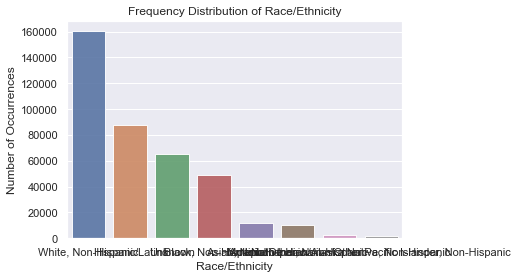

White, Non-Hispanic                                     160413
Hispanic/Latino                                          87827
Unknown                                                  65140
Black, Non-Hispanic                                      48995
Asian, Non-Hispanic                                      11768
Multiple/Other, Non-Hispanic                              9867
American Indian/Alaska Native, Non-Hispanic               2129
Native Hawaiian/Other Pacific Islander, Non-Hispanic      2014
Name: Race and ethnicity (combined), dtype: int64


In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
RaceEthnicity_count = COVID_df['Race and ethnicity (combined)'].value_counts()
sns.set(style="darkgrid")
sns.barplot(RaceEthnicity_count.index, RaceEthnicity_count.values, alpha=0.9)
plt.title('Frequency Distribution of Race/Ethnicity')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Race/Ethnicity', fontsize=12)
plt.show()
print(RaceEthnicity_count)

In [6]:
print(COVID_df.head(15)) 



   cdc_report_dt pos_spec_dt    onset_dt             current_status     sex  \
0     2020/03/22  2020/03/15  2020/03/11  Laboratory-confirmed case  Female   
5     2020/03/03  2020/03/15  2020/03/03  Laboratory-confirmed case  Female   
9     2020/03/15  2020/03/15  2020/03/30  Laboratory-confirmed case    Male   
12    2020/03/18  2020/03/15  2020/03/13  Laboratory-confirmed case    Male   
17    2020/03/23  2020/03/15  2020/03/14  Laboratory-confirmed case    Male   
23    2020/04/04  2020/03/27  2020/03/27  Laboratory-confirmed case  Female   
25    2020/03/24  2020/03/27  2020/03/24  Laboratory-confirmed case  Female   
32    2020/03/27  2020/03/27  2020/03/27  Laboratory-confirmed case  Female   
34    2020/03/24  2020/03/27  2020/03/24  Laboratory-confirmed case  Female   
35    2020/03/26  2020/03/27  2020/03/26  Laboratory-confirmed case  Female   
40    2020/03/12  2020/03/27  2020/03/12  Laboratory-confirmed case  Female   
66    2020/04/05  2020/03/27  2020/03/15  Laboratory

C:\Users\tlueder\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


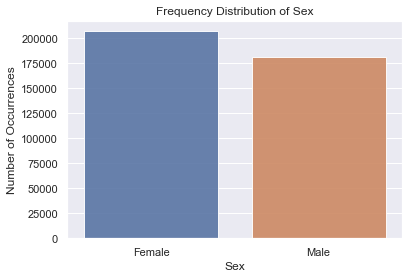

Female    207182
Male      180971
Name: sex, dtype: int64


In [7]:
#COVID_df['death_1'] = np.where(COVID_df['death_yn']!= 'Yes', 1, 0)
#COVID_df['medcond_1'] = np.where(COVID_df['medcond_yn']!= 'Yes', 1, 0)

#mapping = {'0 - 9 Years': 0, '10 - 19 Years': 1}
#COVID_df.replace({'0 - 9 Years': mapping, '10 - 19 Years': mapping})
#COVID_df.head(150)
sex_count = COVID_df['sex'].value_counts()
sns.set(style="darkgrid")
sns.barplot(sex_count.index, sex_count.values, alpha=0.9)
plt.title('Frequency Distribution of Sex')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sex', fontsize=12)
plt.show()
print(sex_count)

C:\Users\tlueder\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


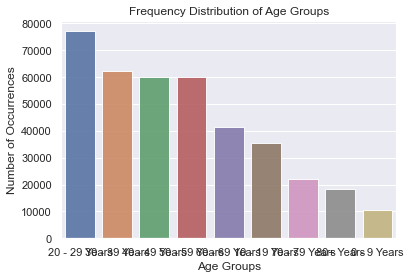

20 - 29 Years    77125
30 - 39 Years    62431
40 - 49 Years    60244
50 - 59 Years    60157
60 - 69 Years    41561
10 - 19 Years    35353
70 - 79 Years    22270
80+ Years        18368
0 - 9 Years      10644
Name: age_group, dtype: int64


In [8]:
ageGroup_count = COVID_df['age_group'].value_counts()
sns.set(style="darkgrid")
sns.barplot(ageGroup_count.index, ageGroup_count.values, alpha=0.9)
plt.title('Frequency Distribution of Age Groups')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Age Groups', fontsize=12)
plt.show()
print(ageGroup_count)

In [9]:
c = COVID_df['Race and ethnicity (combined)'].astype('category')

d_race = dict(enumerate(c.cat.categories))
print (d_race)
COVID_df['Race and ethnicity (combined)'] =COVID_df['Race and ethnicity (combined)'].astype('category').cat.codes
c = COVID_df['age_group'].astype('category')

d_age = dict(enumerate(c.cat.categories))
print (d_age)
COVID_df['age_group'] =COVID_df['age_group'].astype('category').cat.codes
c = COVID_df['sex'].astype('category')

d_sex = dict(enumerate(c.cat.categories))
print (d_sex)
COVID_df['sex'] =COVID_df['sex'].astype('category').cat.codes
c = COVID_df['hosp_yn'].astype('category')

d_hosp = dict(enumerate(c.cat.categories))
print (d_hosp)
COVID_df['hosp_yn'] =COVID_df['hosp_yn'].astype('category').cat.codes
c = COVID_df['icu_yn'].astype('category')

d_icu = dict(enumerate(c.cat.categories))
print (d_icu)
COVID_df['icu_yn'] =COVID_df['icu_yn'].astype('category').cat.codes
c = COVID_df['death_yn'].astype('category')

d_death = dict(enumerate(c.cat.categories))
print (d_death)
COVID_df['death_yn'] =COVID_df['death_yn'].astype('category').cat.codes
c = COVID_df['medcond_yn'].astype('category')

d_medcond = dict(enumerate(c.cat.categories))
print (d_medcond)
COVID_df['medcond_yn'] =COVID_df['medcond_yn'].astype('category').cat.codes


{0: 'American Indian/Alaska Native, Non-Hispanic', 1: 'Asian, Non-Hispanic', 2: 'Black, Non-Hispanic', 3: 'Hispanic/Latino', 4: 'Multiple/Other, Non-Hispanic', 5: 'Native Hawaiian/Other Pacific Islander, Non-Hispanic', 6: 'Unknown', 7: 'White, Non-Hispanic'}
{0: '0 - 9 Years', 1: '10 - 19 Years', 2: '20 - 29 Years', 3: '30 - 39 Years', 4: '40 - 49 Years', 5: '50 - 59 Years', 6: '60 - 69 Years', 7: '70 - 79 Years', 8: '80+ Years'}
{0: 'Female', 1: 'Male'}
{0: 'Missing', 1: 'No', 2: 'Unknown', 3: 'Yes'}
{0: 'Missing', 1: 'No', 2: 'Unknown', 3: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}


In [10]:
COVID_df.head(50)


,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/03/22,2020/03/15,2020/03/11,Laboratory-confirmed case,0,0,4,3,3,0,1
5,2020/03/03,2020/03/15,2020/03/03,Laboratory-confirmed case,0,0,6,1,2,0,0
9,2020/03/15,2020/03/15,2020/03/30,Laboratory-confirmed case,1,0,3,1,1,0,0
12,2020/03/18,2020/03/15,2020/03/13,Laboratory-confirmed case,1,0,4,1,1,0,0
17,2020/03/23,2020/03/15,2020/03/14,Laboratory-confirmed case,1,0,6,1,1,0,0
23,2020/04/04,2020/03/27,2020/03/27,Laboratory-confirmed case,0,1,7,1,0,0,0
25,2020/03/24,2020/03/27,2020/03/24,Laboratory-confirmed case,0,1,7,1,2,0,0
32,2020/03/27,2020/03/27,2020/03/27,Laboratory-confirmed case,0,1,7,1,0,0,1
34,2020/03/24,2020/03/27,2020/03/24,Laboratory-confirmed case,0,1,7,1,0,0,0
35,2020/03/26,2020/03/27,2020/03/26,Laboratory-confirmed case,0,1,7,1,0,0,0


In [11]:
COVID_df = COVID_df.drop(COVID_df.columns[[0,1,2,3]], axis=1)

In [12]:
COVID_df.head(50)


,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,0,0,4,3,3,0,1
5,0,0,6,1,2,0,0
9,1,0,3,1,1,0,0
12,1,0,4,1,1,0,0
17,1,0,6,1,1,0,0
23,0,1,7,1,0,0,0
25,0,1,7,1,2,0,0
32,0,1,7,1,0,0,1
34,0,1,7,1,0,0,0
35,0,1,7,1,0,0,0


In [13]:
#sns.pairplot(COVID_df, hue='death_yn', height=4);

In [14]:
COVIDdf_copy = COVID_df.copy()
corr_matrix = COVIDdf_copy.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper
#COVID_df.head(15)
COVIDdf_copy.head(15)
#COVID_df['Race and ethnicity (combined)'] = COVID_df['Race and ethnicity (combined)'].astype(int)

,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,0,0,4,3,3,0,1
5,0,0,6,1,2,0,0
9,1,0,3,1,1,0,0
12,1,0,4,1,1,0,0
17,1,0,6,1,1,0,0
23,0,1,7,1,0,0,0
25,0,1,7,1,2,0,0
32,0,1,7,1,0,0,1
34,0,1,7,1,0,0,0
35,0,1,7,1,0,0,0


In [15]:
# Checking for any missing values that are still hanging out in the data.
for var in COVID_df.columns:
    print(var, 'percent of missing values', COVID_df[var].isnull().mean().round(9))

for var in COVID_df.columns:
    print(var, COVID_df[var].unique(), '\n')

sex percent of missing values 0.0
age_group percent of missing values 0.0
Race and ethnicity (combined) percent of missing values 0.0
hosp_yn percent of missing values 0.0
icu_yn percent of missing values 0.0
death_yn percent of missing values 0.0
medcond_yn percent of missing values 0.0
sex [0 1] 

age_group [0 1 2 3 5 7 4 6 8] 

Race and ethnicity (combined) [4 6 3 7 2 1 5 0] 

hosp_yn [3 1 2 0] 

icu_yn [3 2 1 0] 

death_yn [0 1] 

medcond_yn [1 0] 



In [16]:
# Label all data columns as categorical, discrete, or continuous, and show the number of features in total. 
# None of our COVID data is continuous, as it can all be counted or categorized.
categorical = ['sex', 'Race and ethnicity (combined)', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn', 'age_group']
COVID_df.columns,'Number of Features:',len(COVID_df.columns)
COVID_df.head(15)

,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,0,0,4,3,3,0,1
5,0,0,6,1,2,0,0
9,1,0,3,1,1,0,0
12,1,0,4,1,1,0,0
17,1,0,6,1,1,0,0
23,0,1,7,1,0,0,0
25,0,1,7,1,2,0,0
32,0,1,7,1,0,0,1
34,0,1,7,1,0,0,0
35,0,1,7,1,0,0,0


In [17]:
# List unique categories for categorical data 
# If there are very few unique categories, we may group them together down the line.
for var in categorical:
    print(var, 'has', COVID_df[var].nunique(), 'unique categories')

sex has 2 unique categories
Race and ethnicity (combined) has 8 unique categories
hosp_yn has 4 unique categories
icu_yn has 4 unique categories
death_yn has 2 unique categories
medcond_yn has 2 unique categories
age_group has 9 unique categories


In [18]:
# List percentage each piece of categorical data makes up of the whole
# If any of the unique categories contain an inconsequential percentage (close to 0%), we may group them together or discard them.
# If we discard those values of low variability, we will have reduced the cardinality of each feature and simplifying the model.
for var in categorical:
    print(COVID_df[var].nunique(),(COVID_df.groupby(var)[var].count()/len(COVID_df)))

2 sex
0                 0.5338
1                 0.4662
Name: sex, dtype: float64
8 Race and ethnicity (combined)
0                 0.0055
1                 0.0303
2                 0.1262
3                 0.2263
4                 0.0254
5                 0.0052
6                 0.1678
7                 0.4133
Name: Race and ethnicity (combined), dtype: float64
4 hosp_yn
0                 0.1463
1                 0.7133
2                 0.0190
3                 0.1215
Name: hosp_yn, dtype: float64
4 icu_yn
0                 0.2526
1                 0.4785
2                 0.2335
3                 0.0355
Name: icu_yn, dtype: float64
2 death_yn
0                 0.9549
1                 0.0451
Name: death_yn, dtype: float64
2 medcond_yn
0                 0.5495
1                 0.4505
Name: medcond_yn, dtype: float64
9 age_group
0                 0.0274
1                 0.0911
2                 0.1987
3                 0.1608
4                 0.1552
5                 0.1550
6     

In [19]:
remap_cat_dict = {
    0: 0,
    1: 0,
    2: 2,
    3: 3,
    4: 4,
    5: 0,
    6: 4,
    7: 7 }
COVID_df.head(15)

,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,0,0,4,3,3,0,1
5,0,0,6,1,2,0,0
9,1,0,3,1,1,0,0
12,1,0,4,1,1,0,0
17,1,0,6,1,1,0,0
23,0,1,7,1,0,0,0
25,0,1,7,1,2,0,0
32,0,1,7,1,0,0,1
34,0,1,7,1,0,0,0
35,0,1,7,1,0,0,0


In [20]:
COVID_df['Race and ethnicity (combined)'] = COVID_df['Race and ethnicity (combined)'].map(remap_cat_dict).astype('category')
#COVID_df['Race and ethnicity (combined)'] = np.trunc(COVID_df['Race and ethnicity (combined)'])
#COVID_df['Race and ethnicity (combined)'] = COVID_df['Race and ethnicity (combined)'].astype(int)
for var in COVID_df.columns:
    print(var, COVID_df[var].unique(), '\n')
COVID_df.head(15)

sex [0 1] 

age_group [0 1 2 3 5 7 4 6 8] 

Race and ethnicity (combined) [4, 3, 7, 2, 0]
Categories (5, int64): [4, 3, 7, 2, 0] 

hosp_yn [3 1 2 0] 

icu_yn [3 2 1 0] 

death_yn [0 1] 

medcond_yn [1 0] 



,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,0,0,4,3,3,0,1
5,0,0,4,1,2,0,0
9,1,0,3,1,1,0,0
12,1,0,4,1,1,0,0
17,1,0,4,1,1,0,0
23,0,1,7,1,0,0,0
25,0,1,7,1,2,0,0
32,0,1,7,1,0,0,1
34,0,1,7,1,0,0,0
35,0,1,7,1,0,0,0


In [21]:
#remap2_cat_dict = {-1: 0, 0: 0, 1: 1 }
#COVID_df['sex'] = COVID_df['sex'].map(remap2_cat_dict).astype('category')
#remap3_cat_dict = {-1: 0, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8 }
#COVID_df['age_group'] = COVID_df['age_group'].map(remap3_cat_dict).astype('category')
#COVID_df
#COVID_df.head(15)

In [22]:
for var in categorical:
    print(var, 'has', COVID_df[var].nunique(), 'unique categories')

sex has 2 unique categories
Race and ethnicity (combined) has 5 unique categories
hosp_yn has 4 unique categories
icu_yn has 4 unique categories
death_yn has 2 unique categories
medcond_yn has 2 unique categories
age_group has 9 unique categories


In [23]:
for var in categorical:
    print(COVID_df[var].nunique(),(COVID_df.groupby(var)[var].count()/len(COVID_df)))

2 sex
0                 0.5338
1                 0.4662
Name: sex, dtype: float64
5 Race and ethnicity (combined)
0                 0.0410
2                 0.1262
3                 0.2263
4                 0.1932
7                 0.4133
Name: Race and ethnicity (combined), dtype: float64
4 hosp_yn
0                 0.1463
1                 0.7133
2                 0.0190
3                 0.1215
Name: hosp_yn, dtype: float64
4 icu_yn
0                 0.2526
1                 0.4785
2                 0.2335
3                 0.0355
Name: icu_yn, dtype: float64
2 death_yn
0                 0.9549
1                 0.0451
Name: death_yn, dtype: float64
2 medcond_yn
0                 0.5495
1                 0.4505
Name: medcond_yn, dtype: float64
9 age_group
0                 0.0274
1                 0.0911
2                 0.1987
3                 0.1608
4                 0.1552
5                 0.1550
6                 0.1071
7                 0.0574
8                 0.0473
Name: 

In [24]:
COVID_df[categorical] = COVID_df[categorical].astype('O')
COVID_df['death_yn'] = COVID_df['death_yn'].astype(int)
COVID_df['death_yn'] *= 1

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(
    COVID_df.drop('death_yn', axis=1),
    COVID_df['death_yn'],
    test_size=0.3,
    random_state=SEED)
print (COVID_df.dtypes)


sex                              object
age_group                        object
Race and ethnicity (combined)    object
hosp_yn                          object
icu_yn                           object
death_yn                          int32
medcond_yn                       object
dtype: object


In [25]:
feat_transform = make_pipeline(ce.OneHotCategoricalEncoder(variables=['sex', 'Race and ethnicity (combined)', 'hosp_yn', 'icu_yn', 'medcond_yn', 'age_group'],drop_last=True))


In [26]:
feat_transform.fit(X_train, y_train)
X_train_clean = feat_transform.transform(X_train)
X_test_clean = feat_transform.transform(X_test)
X_train_clean.head()


,sex_0,Race and ethnicity (combined)_4,Race and ethnicity (combined)_3,Race and ethnicity (combined)_7,Race and ethnicity (combined)_0,hosp_yn_1,hosp_yn_0,hosp_yn_3,icu_yn_1,icu_yn_2,icu_yn_0,medcond_yn_0,age_group_1,age_group_0,age_group_3,age_group_6,age_group_5,age_group_4,age_group_2,age_group_7
2889294,1,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0
4053723,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0
2946547,1,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0
1490217,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1353269,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [27]:
scaler = StandardScaler()
scaler.fit(X_train_clean)
X_train_std = scaler.transform(X_train_clean)
X_test_std = scaler.transform(X_test_clean)
X_train_clean.head()
list(X_train_clean.columns)

['sex_0',
 'Race and ethnicity (combined)_4',
 'Race and ethnicity (combined)_3',
 'Race and ethnicity (combined)_7',
 'Race and ethnicity (combined)_0',
 'hosp_yn_1',
 'hosp_yn_0',
 'hosp_yn_3',
 'icu_yn_1',
 'icu_yn_2',
 'icu_yn_0',
 'medcond_yn_0',
 'age_group_1',
 'age_group_0',
 'age_group_3',
 'age_group_6',
 'age_group_5',
 'age_group_4',
 'age_group_2',
 'age_group_7']

In [28]:
X_train_std_df = pd.DataFrame(X_train_std, columns = X_train_clean.columns)
X_test_std_df = pd.DataFrame(X_test_std, columns = X_test_clean.columns)
X_train_std_df.head()
X_test_std_df.head()


,sex_0,Race and ethnicity (combined)_4,Race and ethnicity (combined)_3,Race and ethnicity (combined)_7,Race and ethnicity (combined)_0,hosp_yn_1,hosp_yn_0,hosp_yn_3,icu_yn_1,icu_yn_2,icu_yn_0,medcond_yn_0,age_group_1,age_group_0,age_group_3,age_group_6,age_group_5,age_group_4,age_group_2,age_group_7
0,0.9356,2.0447,-0.5412,-0.8391,-0.2069,0.6337,-0.4142,-0.3713,1.0447,-0.5521,-0.5819,-1.1048,-0.3170,-0.1690,-0.4378,-0.3463,-0.4270,-0.4287,-0.4976,-0.2469
1,-1.0688,-0.4891,1.8477,-0.8391,-0.2069,-1.5780,-0.4142,2.6929,-0.9572,-0.5521,-0.5819,-1.1048,-0.3170,-0.1690,-0.4378,-0.3463,-0.4270,-0.4287,-0.4976,-0.2469
2,-1.0688,2.0447,-0.5412,-0.8391,-0.2069,0.6337,-0.4142,-0.3713,-0.9572,1.8114,-0.5819,0.9051,-0.3170,-0.1690,-0.4378,-0.3463,-0.4270,-0.4287,2.0096,-0.2469
3,0.9356,2.0447,-0.5412,-0.8391,-0.2069,0.6337,-0.4142,-0.3713,1.0447,-0.5521,-0.5819,0.9051,-0.3170,-0.1690,-0.4378,2.8873,-0.4270,-0.4287,-0.4976,-0.2469
4,0.9356,-0.4891,1.8477,-0.8391,-0.2069,-1.5780,-0.4142,2.6929,-0.9572,-0.5521,-0.5819,-1.1048,-0.3170,-0.1690,-0.4378,-0.3463,-0.4270,2.3325,-0.4976,-0.2469


In [29]:
models = []
models.append(('log_reg', LogisticRegression(max_iter=10000, random_state=42)))
models.append(('rf_classifer', RandomForestClassifier(random_state=42)))
models.append(('bayes', GaussianNB()))
models.append(('gbc', GradientBoostingClassifier()))
base_model_train = []
base_model_test = []
for name, classifier in models:
    scores = cross_val_score(classifier, X_train_std_df, y_train, cv=5, scoring='recall')
    base_model_train.append(scores.mean().round(4))
    print(scores)
    print('{}: Avg CV recall using all features on training data: {}'.format(name, scores.mean().round(4)))
    
    classifier.fit(X_train_std_df, y_train)
    y_preds = classifier.predict(X_test_std_df)
    test_recall = recall_score(y_test, y_preds, average='binary')
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    base_model_test.append(test_recall.round(4))
    print('{}: Recall w/all features on test data {}:'.format(name, test_recall.round(4)))
    print(test_class)
    print(cnf_matrix)
    print('-------------------------------------------------------')

[0.3771 0.3836 0.3808 0.384  0.3921]
log_reg: Avg CV recall using all features on training data: 0.3835
log_reg: Recall w/all features on test data 0.3869:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    111300
           1       0.55      0.39      0.45      5146

    accuracy                           0.96    116446
   macro avg       0.76      0.69      0.72    116446
weighted avg       0.95      0.96      0.96    116446

[[109666   1634]
 [  3155   1991]]
-------------------------------------------------------
[0.3545 0.3492 0.3553 0.3662 0.3597]
rf_classifer: Avg CV recall using all features on training data: 0.357
rf_classifer: Recall w/all features on test data 0.3785:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    111300
           1       0.58      0.38      0.46      5146

    accuracy                           0.96    116446
   macro avg       0.77      0.68      0.72

In [30]:
from imblearn.pipeline import make_pipeline
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_std_sm, y_train_sm = sm.fit_resample(X_train_std_df, y_train)
model1_train = []
model1_test = []
for name, classifier in models:
    pipeline = make_pipeline(sm, classifier)
    scores = cross_val_score(pipeline, X_train_std_df, y_train, cv=5, scoring='recall')
    model1_train.append(scores.mean().round(4))
    print(scores)
    print('{}: Avg CV Recall w/All Reatures: {}'.format(name, scores.mean().round(4)))
    
    classifier.fit(X_train_std_sm, y_train_sm)
    y_preds = classifier.predict(X_test_std_df)
    test_recall = recall_score(y_test, y_preds)
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    model1_test.append(test_recall.round(4))
    print('{}: Recall w/All Features on test data {}:'.format(name, test_recall.round(4)))
    print(test_class)
    print(cnf_matrix)
    print('-------------------------------------------------------')

[0.9321 0.9256 0.9119 0.9293 0.9248]
log_reg: Avg CV Recall w/All Reatures: 0.9247
log_reg: Recall w/All Features on test data 0.9298:
              precision    recall  f1-score   support

           0       1.00      0.90      0.94    111300
           1       0.30      0.93      0.45      5146

    accuracy                           0.90    116446
   macro avg       0.65      0.91      0.70    116446
weighted avg       0.97      0.90      0.92    116446

[[99963 11337]
 [  361  4785]]
-------------------------------------------------------
[0.9155 0.9216 0.9046 0.9139 0.9224]
rf_classifer: Avg CV Recall w/All Reatures: 0.9156
rf_classifer: Recall w/All Features on test data 0.9277:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    111300
           1       0.29      0.93      0.44      5146

    accuracy                           0.90    116446
   macro avg       0.64      0.91      0.69    116446
weighted avg       0.96      0.90 

In [31]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_selector.fit(X_train_std_sm, y_train_sm)
feature_imp = pd.Series(rf_selector.feature_importances_, index=X_train_std_df.columns).sort_values(ascending=False)
print(feature_imp)

hosp_yn_3                                       0.2600
medcond_yn_0                                    0.1914
hosp_yn_1                                       0.1106
age_group_2                                     0.0695
age_group_3                                     0.0533
age_group_5                                     0.0523
age_group_4                                     0.0487
age_group_6                                     0.0362
age_group_1                                     0.0345
icu_yn_1                                        0.0223
age_group_7                                     0.0205
sex_0                                           0.0197
icu_yn_0                                        0.0153
hosp_yn_0                                       0.0151
Race and ethnicity (combined)_7                 0.0146
Race and ethnicity (combined)_3                 0.0129
age_group_0                                     0.0105
icu_yn_2                                        0.0060
Race and e

In [32]:
sum(feature_imp[0:10])

0.8788063053297978

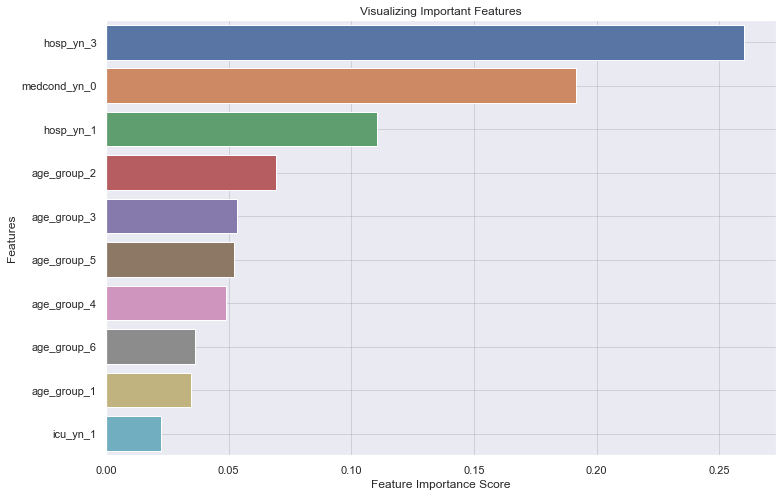

In [33]:
X_train_rf = X_train_std_df[feature_imp[:10].index]
X_test_rf = X_test_std_df[feature_imp[:10].index]
plt.figure(figsize=(12,8))
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.grid(b=False, which='major', color='#666666', linestyle='-', alpha=0.2)
plt.show()

In [34]:
print (d_race)
print (d_age)
print (d_sex)
print (d_hosp)
print (d_icu)
print (d_death)
print (d_medcond)

#{0: 'American Indian/Alaska Native, Non-Hispanic', 1: 'Asian, Non-Hispanic', 2: 'Black, Non-Hispanic', 3: 'Hispanic/Latino', 4: 'Multiple/Other, Non-Hispanic', 5: 'Native Hawaiian/Other Pacific Islander, Non-Hispanic', 6: 'Unknown', 7: 'White, Non-Hispanic'}
#{0: '0 - 9 Years', 1: '10 - 19 Years', 2: '20 - 29 Years', 3: '30 - 39 Years', 4: '40 - 49 Years', 5: '50 - 59 Years', 6: '60 - 69 Years', 7: '70 - 79 Years', 8: '80+ Years'}
#{0: 'Female', 1: 'Male'}
#{0: 'Missing', 1: 'No', 2: 'Unknown', 3: 'Yes'}
#{0: 'Missing', 1: 'No', 2: 'Unknown', 3: 'Yes'}
#{0: 'No', 1: 'Yes'}
#{0: 'No', 1: 'Yes'}

{0: 0, 1: 2, 2: 3, 3: 4, 4: 7}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}
{0: 0, 1: 1}
{0: 0, 1: 1, 2: 2, 3: 3}
{0: 0, 1: 1, 2: 2, 3: 3}
{0: 0, 1: 1}
{0: 0, 1: 1}


In [35]:
models = []
models.append(('log_reg', LogisticRegression(max_iter=10000, random_state=42)))
models.append(('rf_classifer', RandomForestClassifier(random_state=42)))
models.append(('bayes', GaussianNB()))
models.append(('gbc', GradientBoostingClassifier()))
model2_train = []
model2_test = []
for name, classifier in models:
    scores = cross_val_score(classifier, X_train_rf, y_train, cv=5, scoring='recall')
    model2_train.append(scores.mean().round(3))
    print(scores)
    print('{}: Avg CV Recall on RF Features: {}'.format(name, scores.mean().round(3)))
    
    classifier.fit(X_train_rf, y_train)
    y_preds = classifier.predict(X_test_rf)
    test_recall = recall_score(y_test, y_preds, average='binary')
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    model2_test.append(test_recall.round(3))
    print('{}: Recall w/RF features on test data {}:'.format(name, test_recall.round(3)))
    print(test_class)
    print(cnf_matrix)
    print('-------------------------------------------------------')

[0.2458 0.2417 0.2454 0.2462 0.2324]
log_reg: Avg CV Recall on RF Features: 0.242
log_reg: Recall w/RF features on test data 0.256:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    111300
           1       0.58      0.26      0.36      5146

    accuracy                           0.96    116446
   macro avg       0.78      0.62      0.67    116446
weighted avg       0.95      0.96      0.95    116446

[[110365    935]
 [  3830   1316]]
-------------------------------------------------------
[0.2458 0.2417 0.2454 0.2462 0.2324]
rf_classifer: Avg CV Recall on RF Features: 0.242
rf_classifer: Recall w/RF features on test data 0.256:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    111300
           1       0.58      0.26      0.36      5146

    accuracy                           0.96    116446
   macro avg       0.78      0.62      0.67    116446
weighted avg       0.95      0.96   

In [37]:
from sklearn.model_selection import StratifiedKFold 
X_train_rf_sm, y_train_sm = sm.fit_resample(X_train_rf, y_train)
models = []
models.append(('log_reg', LogisticRegression(max_iter=10000, random_state=42)))
models.append(('rf_classifer', RandomForestClassifier(random_state=42)))
models.append(('bayes', GaussianNB()))
models.append(('gbc', GradientBoostingClassifier()))
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
skf = StratifiedKFold(n_splits=5)
model3_train = []
model3_test = []
for name, classifier in models:
    pipeline = make_pipeline(sm, classifier)
    scores = cross_val_score(pipeline, X_train_rf, y_train, cv=skf, scoring='recall')
    model3_train.append(scores.mean().round(3))
    print(scores)
    print('{}: Avg CV Recall w/RF Reatures: {}'.format(name, scores.mean().round(3)))
    
    classifier.fit(X_train_rf_sm, y_train_sm)
    y_preds = classifier.predict(X_test_rf)
    test_recall = recall_score(y_test, y_preds, average='binary')
    test_class = classification_report(y_test, y_preds)
    cnf_matrix = confusion_matrix(y_test, y_preds)
    model3_test.append(test_recall.round(3))
    print('{}: Recall w/RF on test data {}:'.format(name, test_recall.round(3)))
    print(test_class)
    print(cnf_matrix)
    print('-------------------------------------------------------')

[0.9325 0.9305 0.924  0.9256 0.9321]
log_reg: Avg CV Recall w/RF Reatures: 0.929
log_reg: Recall w/RF on test data 0.929:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    111300
           1       0.27      0.93      0.41      5146

    accuracy                           0.88    116446
   macro avg       0.63      0.91      0.67    116446
weighted avg       0.96      0.88      0.91    116446

[[98077 13223]
 [  365  4781]]
-------------------------------------------------------
[0.939  0.9317 0.9248 0.9329 0.9333]
rf_classifer: Avg CV Recall w/RF Reatures: 0.932
rf_classifer: Recall w/RF on test data 0.932:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    111300
           1       0.27      0.93      0.42      5146

    accuracy                           0.88    116446
   macro avg       0.63      0.91      0.68    116446
weighted avg       0.96      0.88      0.91    116446

[[981

In [38]:
classifiers = ['Log_Regression', 'Random_Forest', 'Naive_Bayes', 'Gradient_Boosting_clf']
idx = ['All_Feat_Imbalance_Train', 'All_Feat_Imbalance_Test','All_Feat_Smote_Train',
'All_Feat_Smote_Test','RF_Imbalance_Train', 
'RF_Imbalance_Test','RF_Smote_Train','RF_Smote_Test']
combined_results = pd.DataFrame([base_model_train,base_model_test,
model1_train, model1_test, model2_train,
model2_test, model3_train, model3_test],
columns=classifiers, index=idx)
test_results = pd.DataFrame([base_model_test, model1_test, model2_test, model3_test], columns=classifiers, index=idx[1:8:2])
print(test_results)

                              Log_Regression        Random_Forest  \
All_Feat_Imbalance_Test               0.3869               0.3785   
All_Feat_Smote_Test                   0.9298               0.9277   
RF_Imbalance_Test                     0.2560               0.2560   
RF_Smote_Test                         0.9290               0.9320   

                                 Naive_Bayes  Gradient_Boosting_clf  
All_Feat_Imbalance_Test               0.9227                 0.2658  
All_Feat_Smote_Test                   0.9269                 0.9324  
RF_Imbalance_Test                     0.9430                 0.2560  
RF_Smote_Test                         0.9510                 0.9330  


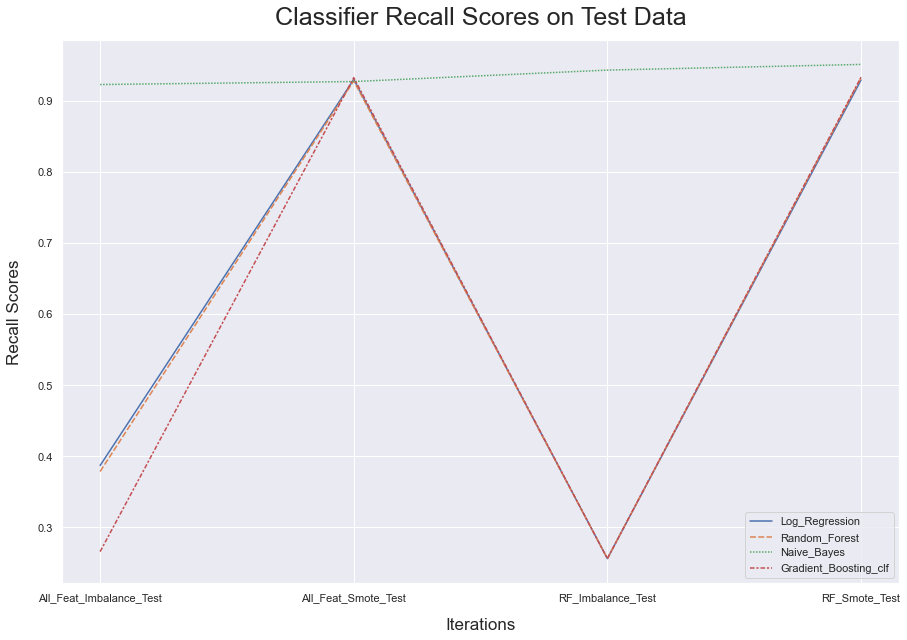

In [39]:
plt.figure(figsize=(15,10))
sns.lineplot(data=test_results[['Log_Regression', 'Random_Forest',
                             'Naive_Bayes', 'Gradient_Boosting_clf']])
plt.xlabel('Iterations', fontsize=17, labelpad=15)             
plt.ylabel('Recall Scores', fontsize=17, labelpad=15)
plt.title('Classifier Recall Scores on Test Data',fontsize=25, pad=15)
plt.show()

In [40]:
clf_lr = LogisticRegression(max_iter=10000, random_state=SEED)
penalty = ['l1','l2']
C = [0.001,0.002,0.003,0.005,1,10,100,1000]
skf = StratifiedKFold(n_splits=5)
pipeline = make_pipeline(sm, clf_lr)
param_grid = dict(logisticregression__penalty=penalty,
                  logisticregression__C=C)
grid = GridSearchCV(pipeline, 
                    param_grid=param_grid,
                    scoring='recall', 
                    verbose=1, cv=skf)
grid_results = grid.fit(X_train_rf, y_train) 
print('Best Score: ', grid_results.best_score_)
print('Best Params: ', grid_results.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none'

C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, go

C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, go

C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, go

C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tlueder\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, go

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  4.9min finished


Best Score:  0.9315278900565886
Best Params:  {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2'}


In [41]:
X_train_rf_sm, y_train_sm = sm.fit_resample(X_train_rf, y_train)
clf_lr = LogisticRegression(max_iter=10000, penalty='l2', C=0.0001, random_state=42)
clf_lr.fit(X_train_rf_sm, y_train_sm)
y_preds = clf_lr.predict(X_test_rf)
test_recall = recall_score(y_test, y_preds).round(3)
test_class = classification_report(y_test, y_preds)
cm = confusion_matrix(y_test, y_preds)
print('Log Regression Recall w/RF on test data {}:'.format(test_recall.round(3)))
print(test_class)
print(cm)

Log Regression Recall w/RF on test data 0.938:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    111300
           1       0.25      0.94      0.40      5146

    accuracy                           0.88    116446
   macro avg       0.63      0.91      0.67    116446
weighted avg       0.96      0.88      0.91    116446

[[97130 14170]
 [  321  4825]]
